In [53]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [54]:
# Direktori dataset
INPUT_DIR = 'dataset'

# Direktori tempat menyimpan model
MODEL_DIR = 'model'
# Buat direktori jika belum ada
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [55]:
# Fungsi untuk load dan ekstrak Mel-spectrogram
def load_and_extract_spectrogram(file_path, n_mels=128, n_fft=2048, hop_length=512, max_time_steps=128):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    if mel_spec_db.shape[1] < max_time_steps:
        pad_width = max_time_steps - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :max_time_steps]
    return mel_spec_db

In [56]:
# Loop melalui setiap folder (kelas)
subdirectories = [subdir for subdir in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, subdir))]


In [57]:
class CustomEarlyStopping(Callback):
    def __init__(self, val_loss_threshold=0.15, val_accuracy_threshold=0.96, patience=3, min_epochs=15):
        super(CustomEarlyStopping, self).__init__()
        self.val_loss_threshold = val_loss_threshold
        self.val_accuracy_threshold = val_accuracy_threshold
        self.patience = patience
        self.min_epochs = min_epochs
        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        val_accuracy = logs.get('val_accuracy')

        # Check if val_loss is below threshold and val_accuracy is above threshold
        if epoch >= self.min_epochs and val_loss < self.val_loss_threshold and val_accuracy > self.val_accuracy_threshold:
            print(f"\n Stopping training as val_loss ({val_loss:.4f}) is below {self.val_loss_threshold} "
                  f"and val_accuracy ({val_accuracy:.4f}) is above {self.val_accuracy_threshold * 100:.2f}%")
            self.model.stop_training = True
            self.stopped_epoch = epoch
        elif self.model.stop_training:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
        else:
            self.wait = 0  # Reset patience if improvement is seen

        # Store the best weights if this is the best result so far
        if val_accuracy > self.val_accuracy_threshold and val_loss < self.val_loss_threshold:
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        # Restore the best weights after training ends
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print("Best weights restored.")
        print(f"Training stopped at epoch {self.stopped_epoch}")

In [58]:
# Array untuk menyimpan metrik pelatihan
training_history = []

for subdir in subdirectories:
    # Skip jika folder adalah folder data salah
    if subdir in ["alif_fathah_salah", "selain_alif_fathah_salah"]:
        continue
        
    print(f"Processing class: {subdir}")
    subdir_path = os.path.join(INPUT_DIR, subdir)
    
    # Load dataset untuk kelas ini
    X = []
    y = []
    wav_files = [file for file in os.listdir(subdir_path) if file.endswith('.wav')]
    
    for wav_file in wav_files:
        file_path = os.path.join(subdir_path, wav_file)
        spectrogram = load_and_extract_spectrogram(file_path)
        X.append(spectrogram)
        y.append(1)  # Label 1 untuk kelas positif (suara benar)

    # Tambahkan data negatif dari folder yang sesuai
    if subdir == "01. alif_fathah":
        wrong_dir = os.path.join(INPUT_DIR, "07. ta_fathah")
    elif subdir == "02. alif_kasroh":
        wrong_dir = os.path.join(INPUT_DIR, "08. ta_kasroh")
    elif subdir == "03. alif_dhomah":
        wrong_dir = os.path.join(INPUT_DIR, "09. ta_dommah")
    else:
        if subdir.endswith('fathah'):
            wrong_dir = os.path.join(INPUT_DIR, "01. alif_fathah")
        elif subdir.endswith('kasroh'):
            wrong_dir = os.path.join(INPUT_DIR, "02. alif_kasroh") 
        elif subdir.endswith('dommah'):
            wrong_dir = os.path.join(INPUT_DIR, "03. alif_dommah")
        
    if os.path.exists(wrong_dir):
        wrong_wav_files = [file for file in os.listdir(wrong_dir) if file.endswith('.wav')]
        for wav_file in wrong_wav_files:
            file_path = os.path.join(wrong_dir, wav_file)
            spectrogram = load_and_extract_spectrogram(file_path)
            X.append(spectrogram)
            y.append(0)  # Label 0 untuk kelas negatif (suara salah)

    # Konversi ke numpy array
    X = np.array(X)
    y = np.array(y)

    # Split dataset menjadi train dan test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    # Tambahkan dimensi ekstra untuk CNN
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Definisikan model CNN untuk klasifikasi biner
    model = models.Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2], 1)),  # Gunakan Input secara eksplisit
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Output untuk klasifikasi biner
    ])

    # Kompilasi model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Inisiasi callback CustomEarlyStopping
    custom_early_stopping = CustomEarlyStopping(val_loss_threshold=0.15, val_accuracy_threshold=0.96, patience=3, min_epochs=15)

    # Latih model dan simpan history
    history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[custom_early_stopping])

    # Simpan model ke dalam direktori 'model'
    model.save(os.path.join(MODEL_DIR, f'model_{subdir}.keras'))

    # Evaluasi model
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test accuracy for {subdir}: {test_acc * 100:.2f}%")
    
    # Simpan history pelatihan
    training_history.append({
        'class': subdir,
        'history': history.history,
        'test_accuracy': test_acc,
        'test_loss': test_loss
    })



Processing class: 01. alif_fathah
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.5696 - loss: 9.5340 - val_accuracy: 0.4651 - val_loss: 0.7430
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5471 - loss: 0.7215 - val_accuracy: 0.5116 - val_loss: 0.8020
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.4964 - loss: 0.7804 - val_accuracy: 0.4884 - val_loss: 0.7778
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.5353 - loss: 0.7010 - val_accuracy: 0.5581 - val_loss: 0.6856
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.6076 - loss: 0.6737 - val_accuracy: 0.6512 - val_loss: 0.6822
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5947 - loss: 0.6668 - val_accuracy: 0.4884 - val_loss: 0.6790
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.6707 - loss: 0.6387 - val_accuracy: 0.6279 - val_loss: 0.6738
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.6750 - loss: 0.5987 - val_a

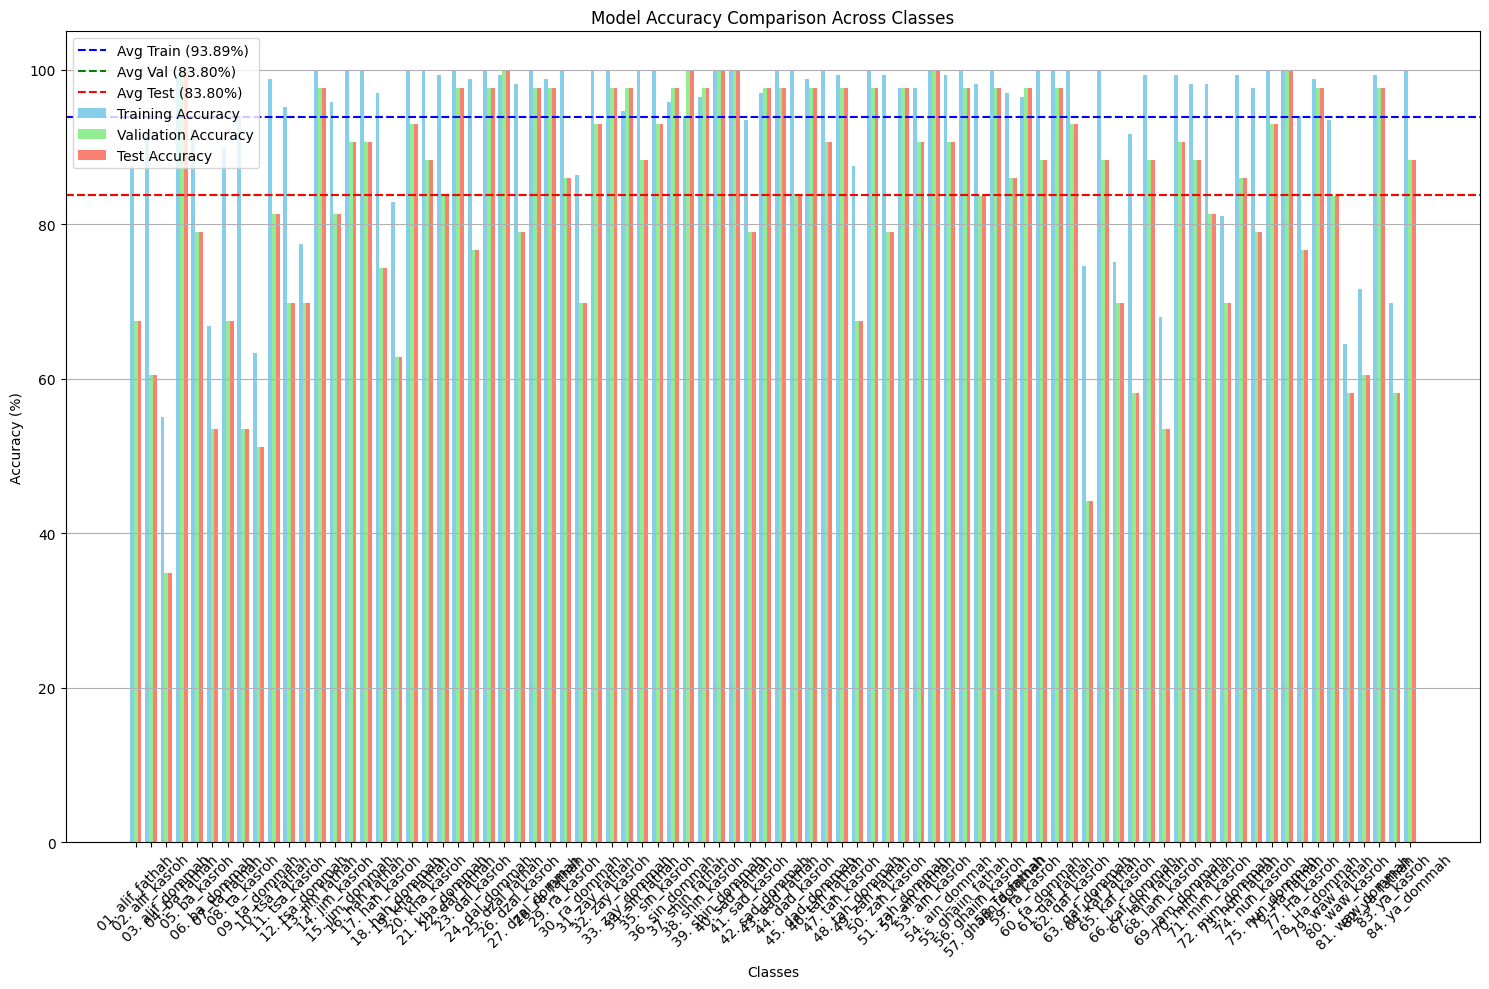


Test Accuracy Summary:
01. alif_fathah: 67.44%
02. alif_kasroh: 60.47%
03. alif_dommah: 34.88%
04. ba_fathah: 100.00%
05. ba_kasroh: 79.07%
06. ba_dommah: 53.49%
07. ta_fathah: 67.44%
08. ta_kasroh: 53.49%
09. ta_dommah: 51.16%
10. tsa_fathah: 81.40%
11. tsa_kasroh: 69.77%
12. tsa_dommah: 69.77%
13. jim_fathah: 97.67%
14. jim_kasroh: 81.40%
15. jim_dommah: 90.70%
16. hah_fathah: 90.70%
17. hah_kasroh: 74.42%
18. hah_dommah: 62.79%
19. kha_fathah: 93.02%
20. kha_kasroh: 88.37%
21. kha_dommah: 83.72%
22. dal_fathah: 97.67%
23. dal_kasroh: 76.74%
24. dal_dommah: 97.67%
25. dzal_fathah: 100.00%
26. dzal_kasroh: 79.07%
27. dzal_dommah: 97.67%
28. ra_fathah: 97.67%
29. ra_kasroh: 86.05%
30. ra_dommah: 69.77%
31. zay_fathah: 93.02%
32. zay_kasroh: 97.67%
33. zay_dommah: 97.67%
34. sin_fathah: 88.37%
35. sin_kasroh: 93.02%
36. sin_dommah: 97.67%
37. shin_fathah: 100.00%
38. shin_kasroh: 97.67%
39. shin_dommah: 100.00%
40. sad_fathah: 100.00%
41. sad_kasroh: 79.07%
42. sad_dommah: 97.67%
43. d

In [60]:
# Plotting hasil pelatihan sebagai bar chart
plt.figure(figsize=(15, 10))

# Persiapkan data untuk plotting
classes = [item['class'] for item in training_history]
test_accuracies = [item['test_accuracy']*100 for item in training_history]
train_accuracies = [item['history']['accuracy'][-1]*100 for item in training_history]
val_accuracies = [item['history']['val_accuracy'][-1]*100 for item in training_history]

# Calculate averages
avg_test = np.mean(test_accuracies)
avg_train = np.mean(train_accuracies)
avg_val = np.mean(val_accuracies)

# Plot accuracies as grouped bar chart
x = np.arange(len(classes))
width = 0.25

plt.bar(x - width, train_accuracies, width, label='Training Accuracy', color='skyblue')
plt.bar(x, val_accuracies, width, label='Validation Accuracy', color='lightgreen')
plt.bar(x + width, test_accuracies, width, label='Test Accuracy', color='salmon')

# Add average lines
plt.axhline(y=avg_train, color='blue', linestyle='--', label=f'Avg Train ({avg_train:.2f}%)')
plt.axhline(y=avg_val, color='green', linestyle='--', label=f'Avg Val ({avg_val:.2f}%)')
plt.axhline(y=avg_test, color='red', linestyle='--', label=f'Avg Test ({avg_test:.2f}%)')

plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison Across Classes')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

# Tampilkan ringkasan hasil test accuracy untuk semua kelas
print("\nTest Accuracy Summary:")
for item in training_history:
    print(f"{item['class']}: {item['test_accuracy']*100:.2f}%")
print(f"\nAverage Accuracies:")
print(f"Training: {avg_train:.2f}%")
print(f"Validation: {avg_val:.2f}%")
print(f"Test: {avg_test:.2f}%")